## Goal:

Here we test the functions: `lbfgsb` in the `Screenkhorn` class.

In [1]:
# NUMPY
import numpy as np
np.random.seed(3946)
# MATPLOTLIB
import matplotlib.pyplot as plt
plt.style.context('dark_background')
%matplotlib inline 
from matplotlib import rc
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Computer Modern Roman']})
params = {'axes.labelsize': 8, # 12
          'font.size': 8, # 12
          'legend.fontsize': 8, # 12
          'xtick.labelsize': 8, # 10
          'ytick.labelsize': 8, # 10
          'text.usetex': True,
          'figure.figsize': (16, 6)}
plt.rcParams.update(params)

# SEABORN 
import seaborn as sns
sns.set_context("poster")
sns.set_style("ticks")

# SKLEARN 
from sklearn.metrics import pairwise_distances

# WARNINGS
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# TIME
from time import time 

# PATH 
import sys
path_files = '/Users/mzalaya/PycharmProjects/OATMIL/oatmilrouen/'
sys.path.insert(0, path_files) 


# POT
import ot
from ot import sinkhorn, emd

# GREENKHORN 
from ot.bregman import greenkhorn

# SCREENKHORN
from screenkhorn.screenkhornBFGS import Screenkhorn


IndentationError: unexpected indent (screenkhorn.py, line 894)

## Data generation

In [2]:
n_1 = 1000# nb samples
n_2 = 1000
mu_s = np.array([0, 0])
cov_s = np.array([[1, 0], [0, 1]])

mu_t = np.array([4, 4])
cov_t = np.array([[1, -.8], [-.8, 1]])

xs = ot.datasets.make_2D_samples_gauss(n_1, mu_s, cov_s)
xt = ot.datasets.make_2D_samples_gauss(n_2, mu_t, cov_t)

a = np.ones((n_1,)) / n_1
b = np.ones((n_2,)) / n_2  # uniform distribution on samples

# a = abs(np.random.normal(size=(n_1,)))
# b = abs(np.random.normal(size=(n_2,)))
# a = a / a.sum()
# b = b / b.sum()

# loss matrix
M = ot.dist(xs, xt)
M /= M.max()

lower_bound_epsilon = M.max()/806
# reg = lower_bound_epsilon
reg = 0.005
lower_bound_epsilon

0.0012406947890818859

## Sinkhorn 

In [3]:
tic = time()
P_sink = sinkhorn(a, b, M, reg, log=True)
Pstar = P_sink[0]
outputs_dict = P_sink[1]
ustar = outputs_dict['u']
vstar = outputs_dict['v']
time_sink = time() - tic

## L-BFGS-B

In [4]:
tic = time()
screenkhorn = Screenkhorn(a, b, M, reg, N=n_1, M=n_2)
lbfgsb = screenkhorn.lbfgsb()
time_bfgs = time() - tic
usc = lbfgsb[0]
vsc = lbfgsb[1]
Psc= lbfgsb[2]

/Users/mzalaya/PycharmProjects/OATMIL/oatmilrouen/screenkhorn/screenkhornBFGS.py:161: RuntimeWarning: divide by zero encountered in log
  part_IJ = u_param @ self.K_IJ @ v_param - self.a_I @ np.log(u_param) - self.b_J @ np.log(v_param)
/Users/mzalaya/PycharmProjects/OATMIL/oatmilrouen/screenkhorn/screenkhornBFGS.py:171: RuntimeWarning: divide by zero encountered in true_divide
  grad_v = self.K_IJ.T @ u_param + self.vec_eps_IcJ - self.b_J / v_param


## Time comparison between Sinkhorn and L-BFGS-B

In [5]:
print('\n')
print("Time of the LBFGS initialization is %s \n" %screenkhorn.toc_initial)
print("Time of Sinkhorn: %s" %time_sink, '\n')
print("Ratio Time: Sinkhorn / class initialization: %s \n" %(time_sink / screenkhorn.toc_initial))
print("Time of LBFGS inculding the class initialization: %s\n" %time_bfgs)
print("Ratio Time: Sinkhorn / LBFGS: %s \n" %(time_sink / time_bfgs))
print("Ratio Time: LBFGS / Sinkhorn : %s" %(time_bfgs / time_sink))



Time of the LBFGS initialization is 0.010243654251098633 

Time of Sinkhorn: 0.039312124252319336 

Ratio Time: Sinkhorn / class initialization: 3.8377051088094962 

Time of LBFGS inculding the class initialization: 0.025825023651123047

Ratio Time: Sinkhorn / LBFGS: 1.5222493029782678 

Ratio Time: LBFGS / Sinkhorn : 0.6569226197335145


## Some plots

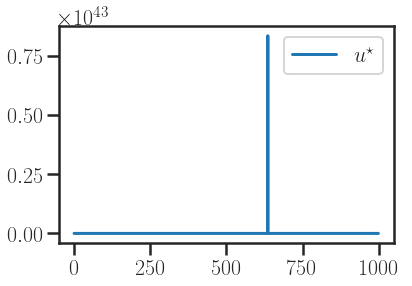

In [6]:
plt.plot(ustar, label=r'$u^\star$')
plt.legend();

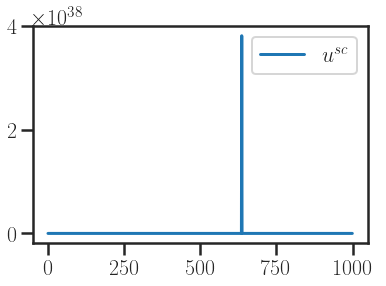

In [7]:
plt.plot(usc, label=r'$u^{sc}$')
plt.legend();

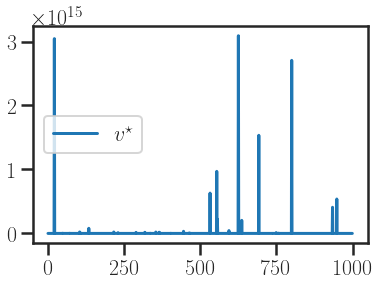

In [8]:
plt.plot(vstar, label=r'$v^\star$')

plt.legend();

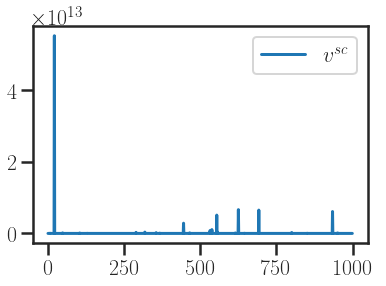

In [9]:
plt.plot(vsc, label=r'$v^{sc}$')
plt.legend();

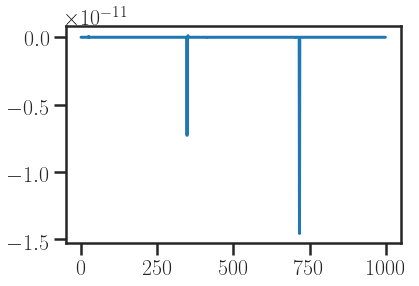

In [10]:
# Gradient w.r.t. u
plt.plot(lbfgsb[3]['grad'][:len(screenkhorn.I)]);

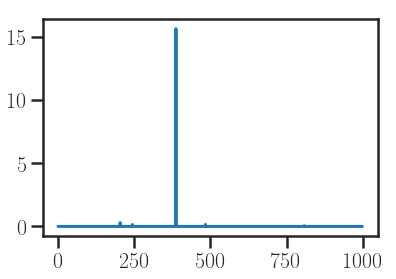

In [11]:
# Gradient w.r.t. v
plt.plot(lbfgsb[3]['grad'][len(screenkhorn.I):]);

In [12]:
# K = np.exp(-M/reg)
# Psc = np.diag(3*usc*1e5)@ K @np.diag(vsc*3*1e4) 

In [13]:
## sinkhorn
astar = Pstar @ np.ones(n_2)
bstar = Pstar.T @ np.ones(n_1)

# screenkhorn via lbfgsb
asc = Psc @ np.ones(n_2)
bsc = Psc.T @ np.ones(n_1)

print("sum of the marginals in sinkhorn are: %s, \t %s" %(sum(astar), sum(bstar)))
print("\t")
print("sum of the marginals in screenkhorn are: %s, \t %s" %(sum(asc), sum(bsc)))
print("\t")
print("Difference in sinkhorn: %s \t %s:" %(abs(1 - sum(astar)), abs(1 - sum(bstar))))
print("\t")
print("Difference in screenkhorn: %s \t  %s:" %(abs(1 - sum(asc)), abs(1 - sum(bsc))))
print("\t")

print("Frobenius norm of difference solution matrices %s " %np.linalg.norm(Pstar - Psc,'fro'))

sum of the marginals in sinkhorn are: 1.0000000000000007, 	 1.0000000000000004
	
sum of the marginals in screenkhorn are: 1.0000000000000007, 	 1.0000000000000013
	
Difference in sinkhorn: 6.661338147750939e-16 	 4.440892098500626e-16:
	
Difference in screenkhorn: 6.661338147750939e-16 	  1.3322676295501878e-15:
	
Frobenius norm of difference solution matrices 0.00784213508671828 


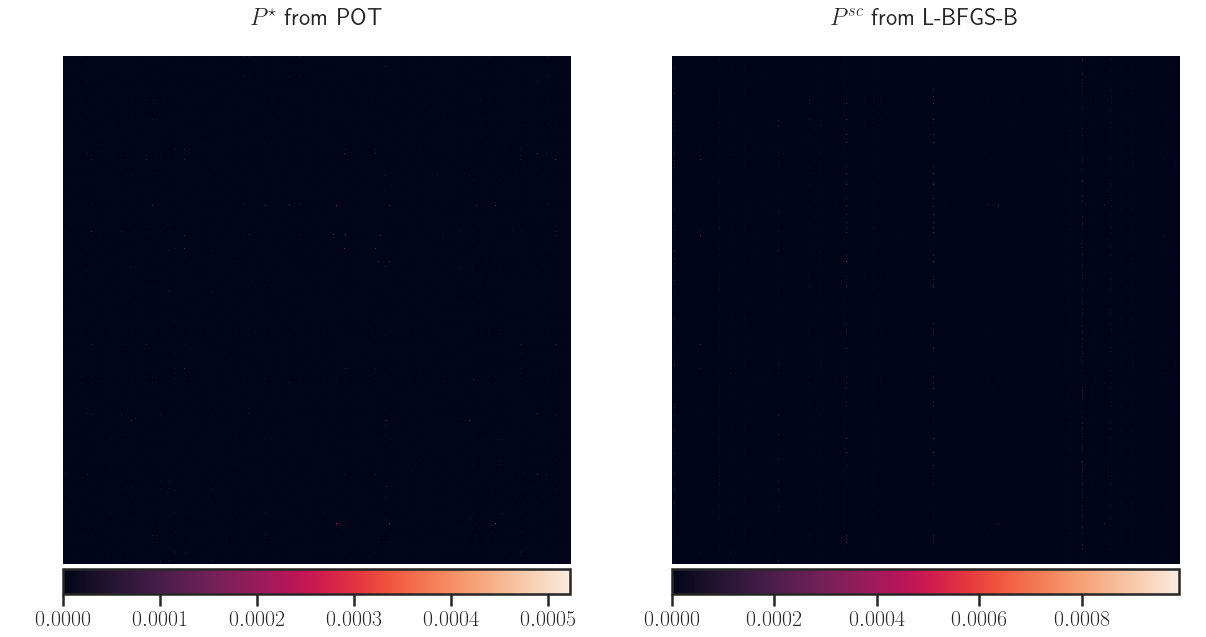

In [14]:
cb_padding = 0.005
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20,20))
I1 = ax1.matshow(Pstar)
ax1.set_title(r'$P^\star$ from POT')
ax1.axis('off')
fig.colorbar(I1, ax=ax1, pad=cb_padding, orientation="horizontal")
ax1.label_outer()
## 
I2 = ax2.matshow(Psc)
ax2.set_title(r'$P^{sc}$ from L-BFGS-B');
# ax2.label_outer()
ax2.axis('off')
fig.colorbar(I2, ax=ax2, pad=cb_padding, orientation="horizontal")
# 
# I3 = ax3.matshow(abs(P_sc_bfgs - P_star))
# ax3.set_title('Difference');
# ax3.label_outer()
# ax3.axis('off');
# fig.colorbar(I3, ax=ax3, pad=cb_padding, orientation="horizontal")
plt.subplots_adjust(hspace=1)

In [15]:
I_active = screenkhorn.I
J_active = screenkhorn.J
epsilon_u = screenkhorn.epsilon_u
epsilon_v = screenkhorn.epsilon_v
I_usc = np.where(usc > epsilon_u)[0].tolist()
J_usc = np.where(vsc > epsilon_v)[0].tolist()

In [16]:
print(len(I_usc), len(I_active))

1000 1000


In [17]:
print(len(J_usc), len(J_active))

1000 1000


In [18]:
print(epsilon_u, epsilon_v)

0.0 0.0
